# MNIST Database

In [17]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
# el as_frame = False evita que la base de datos se importe como dataframe
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:
* A DESCR key describing the dataset
* A data key containing an array with one row per instance and one column per feature
* A target key containing an array with the labels

In [18]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [19]:
y.shape

(70000,)

Hay 70000 imagenes con 784 pixeles cada una (28 x 28 pixeles)

<function matplotlib.pyplot.show(close=None, block=None)>

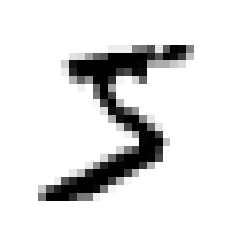

In [21]:
# Visualizacion de una de las imagenes

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show

In [22]:
# Chequeamos que la base de datos diga efectivamente que esto se trata de un 5

y[0]

'5'

In [24]:
# Como los labels estan guardados como string, los pasamos a integrer

import numpy as np

y = y.astype(np.uint8)

In [25]:
# Hay que separar el test set antes de inspeccionar los datos

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Clasificacion Binaria

In [26]:
# Entrenamos un '5-detector'

y_train_5 =(y_train == 5) #True for all 5s
y_test_5 = (y_test == 5)

## Stochastic Gradient Descent (SGD)

In [27]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [28]:
# y ahora usamos el clasificador para predecir la imagen del ppio

sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

* ### Cross-Validation

In [31]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

Da un 95% de accuracy, pero solo porque alrededor del 10% de las muestras corresponden al numero 5

* ### Confusion Matrix

In [33]:
# First I need to have a set of predictions so that the can be compared to the actual targets

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [35]:
# Luego podemos obtener la matriz de confusion

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

El numero de arriba a la izq es el **'true negative'** y el de abajo a la derecha es el **'true positive'**

* ### Precision and Recall (from Confusion Matrix)

In [36]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [37]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

* ### F1 Score (combinacion de precision y recall)

In [39]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

Esta metrica favorece clasificadores que tengan un precision y recall similares

* ### Receiver Operating Characteristic (ROC) Curve

Plots the true positive rate against the false positive rate

NameError: name 'recall_90_precision' is not defined

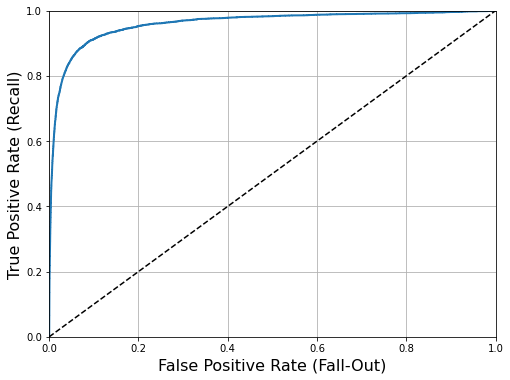

In [42]:
from sklearn.metrics import roc_curve

y_scores = sgd_clf.decision_function([some_digit])
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
fpr, tpr, tresholds = roc_curve(y_train_5, y_scores)

# dps se grafica en matplotlib

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [43]:
# Se pueden usar clasificadores usando el area bajo la curva

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## Random Forest Classifier

<function matplotlib.pyplot.show(close=None, block=None)>

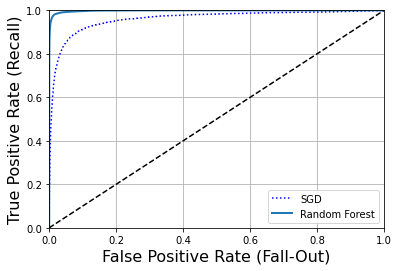

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')

y_scores_forest = y_probas_forest[:, 1] #score = prob of positive class

fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label = 'SGD') # este grafico es del clasificador anterior
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc = 'lower right')
plt.show

In [45]:
# Estimamos el area bajo la curva para el random forest

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

In [46]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # notar que este es el set original, no el especial para diferenciar 5s
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Sklearn detecto que teniamos mas de dos categorias y uso la estrategia 'one-versus-one'.
En este caso entreno 45 clasificadores.

In [47]:
# si llamamos a la funcion decision_function(), devuelve 10 valores por instancia, 
#es el numero de 'won duels' +- pequeños cambios para evitar empates

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [48]:
# el mayor valor corresponde a la clase 5!
np.argmax(some_digit_scores)

5

In [50]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [51]:
svm_clf.classes_[5]

5

En este caso coinciden el numero que tiene que predecir con el indice, pero en general esto no sucede

### Cambiar de estrategia para el clasificador multiclase

In [52]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC()) # Lo basamos en un Support Vector Machine

ovr_clf.fit(X_train, y_train)

ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [53]:
len(ovr_clf.estimators_) #since there are 10 classes, it trained 10 binary classifiers

10

In [54]:
#
## Tambien podemos entrenar SGDClassifier 
#
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [55]:
sgd_clf.decision_function([some_digit]) #aca vemos que el puntaje mayor fue para el numero 5

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [57]:
# Se puede usar Cross_Validation para evaluar el accuracy del clasificador SGD
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [59]:
# Escalando los datos mejora el accuracy

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [60]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)


NameError: name 'conf_ms' is not defined

In [61]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

<function matplotlib.pyplot.show(close=None, block=None)>

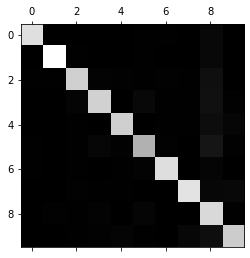

In [62]:
# Image representation of the confussion matrix

plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show

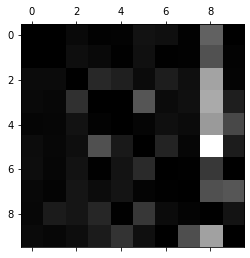

In [63]:
# Ploteando los errores

#Primero dividimos los valores para comparar error rates en lugar de valores absolutos
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

#Llenamos las diagonales con ceros para mantener unicamente los resultados
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()